<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/cheesy.jpg" width="250px"></div>

# Bro to Spark: Cheesy/Easy Way
** NOTE:** This is NOT the correct way to go from Bro to Spark. We're going to be using local data and a local Spark kernel which obviously won't scale at all. But if you just want to explore Spark with some smaller datasets this is a super **EASY** way to get started. 

All you need to install for this notebook/approach is:

    $ pip install bat pyspark 

For the correct (but more complicated) way please see our Bro to Spark notebooks:
- https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Parquet_to_Spark.ipynb
- https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Kafka_to_Spark.ipynb

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/bro.png" width="100px"></div>

You can test whether spark is installed correctly by starting up the spark shell.
    
    $ spark-shell

There are some warnings and stuff but if you get this you have successfully installed spark.
You can quit the shell by typing ':quit' and the scala> prompt
<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark.png" width="250px"></div>
<div style="margin: 20px 20px 20px 20px"><img align="left" src="images/spark_shell.png" width="400px"></div>

In [1]:
from pyspark.sql import SparkSession
from bat import log_to_dataframe
import pandas as pd

In [3]:
# Convert Bro log to Pandas DataFrame
dns_df = log_to_dataframe.LogToDataFrame('../data/dns.log')
dns_df.head()

Successfully monitoring ../data/dns.log...


,AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,...,qclass_name,qtype,qtype_name,query,rcode,rcode_name,rejected,trans_id,ts,uid
0,False,True,True,False,36.000000,0,54.245.228.191,192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,guyspy.com,0,NOERROR,False,44949,2013-09-15 17:44:27.631940,CZGShC2znK1sV7jdI7
1,False,True,True,False,"1000.000000,36.000000",0,"guyspy.com,54.245.228.191",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,www.guyspy.com,0,NOERROR,False,50071,2013-09-15 17:44:27.696869,CZGShC2znK1sV7jdI7
2,False,True,True,False,"60.000000,60.000000,60.000000,60.000000,60.000...",0,"54.230.86.87,54.230.86.18,54.230.87.160,54.230...",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,devrubn8mli40.cloudfront.net,0,NOERROR,False,39062,2013-09-15 17:44:28.060639,CZGShC2znK1sV7jdI7
3,False,True,True,False,"60.000000,60.000000,60.000000,60.000000,60.000...",0,"54.230.86.87,54.230.86.18,54.230.84.20,54.230....",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,d31qbv1cthcecs.cloudfront.net,0,NOERROR,False,7312,2013-09-15 17:44:28.141795,CZGShC2znK1sV7jdI7
4,False,True,True,False,"4993.000000,129.000000,129.000000,129.000000",0,"cdn.entrust.net.c.footprint.net,192.221.123.25...",192.168.33.10,1030,4.2.2.3,...,C_INTERNET,1,A,crl.entrust.net,0,NOERROR,False,41872,2013-09-15 17:44:28.422704,CZGShC2znK1sV7jdI7


<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark.png" width="200px"></div>

# Spark It!
### Spin up Spark with 4 Parallel Executors
Here we're spinning up a local spark server with 4 parallel executors, although this might seem a bit silly since we're probably running this on a laptop, there are a couple of important observations:

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark_jobs.png" width="400px"></div>

- If you have 4/8 cores use them!
- It's the exact same code logic as if we were running on a distributed cluster.
- We run the same code on **DataBricks** (www.databricks.com) which is awesome BTW.

In [5]:
# Spin up a local Spark Session (with 4 executors)
spark = SparkSession.builder.master('local[4]').appName('my_awesome').getOrCreate()

In [6]:
# Convert to Spark DF
spark_df = spark.createDataFrame(dns_df)

In [7]:
# Some simple spark operations
num_rows = spark_df.count()
print("Number of Spark DataFrame rows: {:d}".format(num_rows))
columns = spark_df.columns
print("Columns: {:s}".format(','.join(columns)))

Number of Spark DataFrame rows: 51
Columns: AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,qclass,qclass_name,qtype,qtype_name,query,rcode,rcode_name,rejected,trans_id,ts,uid


In [8]:
# Some simple spark operations
spark_df.groupBy('proto').count().show()

+-----+-----+
|proto|count|
+-----+-----+
|  tcp|    3|
|  udp|   48|
+-----+-----+



<div style="float: right; margin: 0px 0px 0px -30px"><img src="images/confused.jpg" width="150px"></div>
### Note: Spark/PySpark does not like column names with a '.' in them
So for the fields like 'id.orig_h' we have to put the backticks around them ( \`id.orig_h\` )

In [9]:
# Some simple spark operations
spark_df.groupBy('`id.orig_h`', '`id.resp_h`').count().show()

+-------------+---------+-----+
|    id.orig_h|id.resp_h|count|
+-------------+---------+-----+
|192.168.33.10|  8.8.8.8|   12|
|192.168.33.10|  4.2.2.3|   39|
+-------------+---------+-----+



In [10]:
# Add a column with the string length of the DNS query
from pyspark.sql.functions import col, length

# Create new dataframe that includes new column
spark_df = spark_df.withColumn('query_length', length(col('query')))
spark_df[['query', 'query_length']].show()

+--------------------+------------+
|               query|query_length|
+--------------------+------------+
|          guyspy.com|          10|
|      www.guyspy.com|          14|
|devrubn8mli40.clo...|          28|
|d31qbv1cthcecs.cl...|          29|
|     crl.entrust.net|          15|
|   crl3.digicert.com|          17|
|stats.g.doublecli...|          23|
|www.googletagserv...|          25|
|dev.visualwebsite...|          30|
|partner.googleads...|          28|
|www.google-analyt...|          24|
|d5nxst8fruw4z.clo...|          28|
|pubads.g.doublecl...|          24|
|tag.gayadnetwork.com|          20|
|      cdn.guyspy.com|          14|
|pagead2.googlesyn...|          29|
|        ib.adnxs.com|          12|
|googleads.g.doubl...|          27|
|    www.facebook.com|          16|
|   lax1.ib.adnxs.com|          17|
+--------------------+------------+
only showing top 20 rows



In [11]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
from bat.utils import plot_utils
plot_utils.plot_defaults()

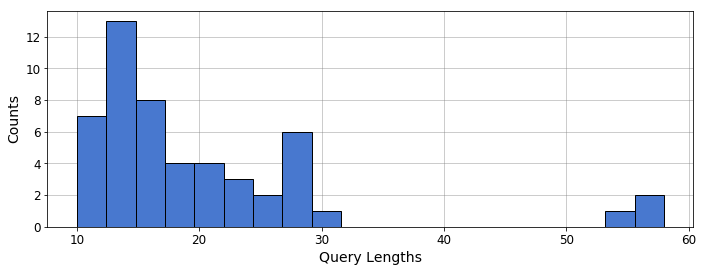

In [12]:
# Show histogram of the Spark DF query lengths
bins, counts = spark_df.select('query_length').rdd.flatMap(lambda x: x).histogram(20)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid(True)
plt.xlabel('Query Lengths')
plt.ylabel('Counts')

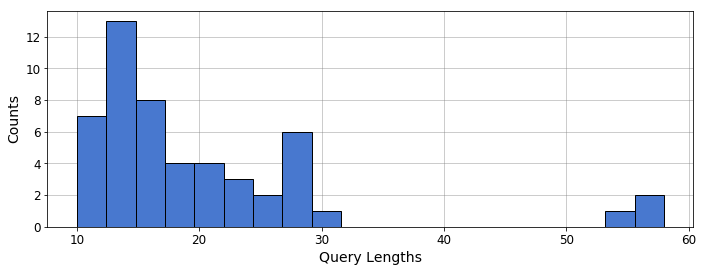

In [13]:
# Compare the computation of query_length and resulting histogram with Pandas
dns_df['query_length'] = dns_df['query'].str.len()
dns_df['query_length'].hist(bins=20)
plt.xlabel('Query Lengths')
plt.ylabel('Counts')

<div style="float: right; margin: 20px 0px 0px 0px"><img src="images/spark.png" width="150px"></div>

# That was easy.. is this the same as 'real' Spark?
Yep, if you've gotten this far you are running a local instance of the Spark server with all the exact same functionality as any Spark cluster (minus the scalability that comes with lots of nodes obviously).

Check out your Spark jobs by simply going to http://localhost:4040

<div style="margin: 20px 0px 0px 0px"><img src="images/spark_jobs.png" width="600px"></div>

## Wrap Up
Well that's it for this notebook. With a few simple pip installs you are ready to try out Spark on your Bro Logs. Yes it will only work on smaller data but it gets you **'in the saddle'** quickly. You can try some stuff out, get familiar with Spark and then dive into setting it up the right way:
<div style="float: right; margin: 0px 0px 0px 0px"><img src="https://www.kitware.com/img/small_logo_over.png" width="200px"></div>
- https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Parquet_to_Spark.ipynb
- https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Kafka_to_Spark.ipynb

If you liked this notebook please visit the [bat](https://github.com/Kitware/bat) project for more notebooks and examples.
